<a href="https://colab.research.google.com/github/adesam146/nlpcw/blob/rest_of_tasks_playground/NLP_CW_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check GPU memory

In [2]:
#Check GPU Memory allocation
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.9 GB  | Proc size: 143.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
#run this if GPU utilization is not 0%
# !kill -9 -1

## Imports

In [4]:
!pip install -U spacy ftfy torchtext
!python -m spacy download en
!pip install -U textblob #Sentiment analysis
!python -m textblob.download_corpora

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.0.18)
Requirement already up-to-date: ftfy in /usr/local/lib/python3.6/dist-packages (5.5.1)
Requirement already up-to-date: torchtext in /usr/local/lib/python3.6/dist-packages (0.3.1)

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

    100% |████████████████████████████████| 645kB 23.8MB/s 
  Found existing installation: textblob 0.15.2
    Uninstalling textblob-0.15.2:
      Successfully uninstalled textblob-0.15.2
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler
from torch import autograd
import spacy
from torchtext import data
from torchtext import datasets as nlp_dset
import random
from sklearn.utils import resample
import numpy as np
import pandas as pd
from textblob import TextBlob

import torchvision.transforms as T

nlp_spaCy = spacy.load('en', disable=["tagger", "parser", "ner"])

#stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stops_nltk = list(stopwords.words('english'))
stops_sklearn = list(ENGLISH_STOP_WORDS)
STOPWORDS = list(set(stops_nltk + stops_sklearn))

#GPU
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print("Using device:", device)

#Fix all seeds
SEED = 0

def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
set_seed()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using device: cuda:0


In [6]:
# Load datafiles from own google drive
from google.colab import drive
drive.mount('/content/drive')
train_fp = """/content/drive/My Drive/colab_data/offenseval-training-v1.tsv"""
train_df = pd.read_csv(train_fp, delimiter="\t")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ELMO

In [7]:
!pip install torchvision torch allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids

    100% |████████████████████████████████| 5.6MB 1.2MB/s 
    100% |████████████████████████████████| 2.0MB 14.3MB/s 
    100% |████████████████████████████████| 552kB 24.1MB/s 
    100% |████████████████████████████████| 12.6MB 2.7MB/s 
    100% |████████████████████████████████| 1.5MB 19.2MB/s 
    100% |████████████████████████████████| 122kB 31.8MB/s 
    100% |████████████████████████████████| 512kB 21.6MB/s 
    100% |████████████████████████████████| 133kB 34.9MB/s 
    100% |████████████████████████████████| 51kB 21.3MB/s 
    100% |████████████████████████████████| 4.5MB 8.9MB/s 
    100% |████████████████████████████████| 2.4MB 11.2MB/s 
    100% |████████████████████████████████| 143kB 24.0MB/s 
    100% |████████████████████████████████| 61kB 24.1MB/s 
    100% |████████████████████████████████| 51kB 21.2MB/s 
    100% |████████████████████████████████| 51kB 5.9MB/s 
    100% |████████████████████████████████| 7.5MB 4.6MB/s 
    100% |████████████████████████████████| 92kB

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [0]:
#Use pretrained ELMO weights. 
options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"

elmo = Elmo(options_file, weight_file, 2, dropout=0)

100%|██████████| 374434792/374434792 [00:21<00:00, 17177971.67B/s]


In [0]:
#Elmo test
sentences = [['First', 'sentence', '.'], ['Another', '.'], 
             ["Oh", "here", "we", "Go", "now", "you", "fool", "."], 
             ["meaninglesswordnotinvocab"]]
             
character_ids = batch_to_ids(sentences)

embeddings = elmo(character_ids)

print(character_ids.shape)
embed = embeddings["elmo_representations"]
print(len(embed))
print(embed[0].shape)
print(embed[1].shape)


torch.Size([4, 8, 50])
2
torch.Size([4, 8, 1024])
torch.Size([4, 8, 1024])


In [0]:
# ELMO takes a list of parsed sentences as an input
# It generates an embedding of length 1024 per word
# We then need to find a good method of combining the word vecs to create 
# a sentence embedding (this article is good: https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a). 


## Import and preprocess Data

In [0]:
import string

def tokenize(text, params):
    """tokenizes, and optionally also:
        1) replaces words with their lemmatized forms
        2) removes punctuation
        3) removes english stopwords. 
    """
    
    lemmatize = params.get("lemmatize")
    rem_punct = params.get("rem_punct")
    rem_stopwords = params.get("rem_stopwords")
    
    #deal with stopwords
    if rem_stopwords:
        stopwords = STOPWORDS
    else:
        stopwords = []
    
    #deal with no punctuation
    if rem_punct:
        stoptokens = [x for x in list(string.punctuation) if x not in list("#$&*@")]
        stoptokens += stopwords
    else:
        stoptokens = stopwords 
    #stoptokens will be removed from tokens
        
    #replace each sentence with its lemmatized counterpart
    if not lemmatize:
        result = [tok.text for tok in nlp_spaCy.tokenizer(text) if tok.text not in stoptokens]
    else:
        #otherwise: lemmatize
        tweet = nlp_spaCy(text)  #SpaCy tokenizes and does POS and lemmatization on tokens 
        tokens = []
        for counter, token in enumerate(tweet):
            if token.lemma_ == "-PRON-":         #treat pronouns differently as SpaCy replaces all of them with "-PRON-"
                tokens.append(token.text)        #which therefore becomes a common token that biases results
            #For everything else, add the lemma:
            else:
                tokens.append(token.lemma_)
        result = [tok for tok in tokens if tok not in stoptokens]
    return result

## Task A

In [9]:
# Use two GloVe trained on two different corpuses for comparison:
    # Glove.6B
    # glove.twitter.27B
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

--2019-02-27 08:14:27--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2019-02-27 08:14:27--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  2.12MB/s    in 10m 52s 

2019-02-27 08:25:20 (2.22 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [0]:
def tokenizer(text): # create a tokenizer function for gloVe
    res = [tok.text for tok in nlp_spaCy.tokenizer(text) if tok.text not in STOPWORDS]
    return res


In [11]:
#Create fields
BATCH_SIZE = 128


TEXT = data.Field(sequential=True, tokenize=tokenizer, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a',LABEL),
               ('subtask_b',LABEL),
               ('subtask_c',LABEL)]


train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=None)

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_a)

output_dim = len(LABEL.vocab)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

# For retrieving tweet text later on
train_df = pd.read_csv(train_fp, delimiter="\t")

Train size: 10592
Validation size: 2648


100%|█████████▉| 1193102/1193514 [01:47<00:00, 11072.34it/s]


In [83]:
print('first tweet', train[0].tweet)
print('first label', train[0].subtask_a)
print("first tweet id:", train[0].id)
# print(TEXT.vocab.stoi) # word to index
# print(LABEL.vocab.stoi) # word to index


first tweet ['@user', '@user', 'a', 'read', '!', 'url']
first label NOT
first tweet id: 29719


In [37]:
#check loader
for idx, batch in enumerate(train_iterator):
    inputs, labels = batch.tweet, batch.subtask_a
    print(inputs.shape)
    print(labels.shape)
    print(len(train_iterator))
    
    break

torch.Size([128, 49])
torch.Size([128])
83


In [0]:
from sklearn import metrics 

def check_accuracy(task_header, loader, model, conf=False, RNN=False):
    """
    Note at the moment this function assumes the batch size is equal to the 
    number of data in the loader when calculating the confusion matrix
    """
    num_correct = 0
    num_samples = 0
    
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, getattr(batch, task_header)
            y = y.view(-1, 1)
                
            x = x.to(device=device, dtype=torch.long)  # move to  GPU
            y = y.to(device=device, dtype=torch.long)
            
            if RNN:
                #Must zero all of the accumalated hidden state for the RNN
                model.hidden = model.init_hidden(batch.batch_size)
                
            logits = model(x, ids = batch.id)
            if task_header == 'subtask_c':
                pred_prob = F.softmax(logits, dim=1)
                pred_1 = torch.argmax(pred_prob, dim=1).view(-1, 1)
            else:
                pred_prob = torch.sigmoid(logits)
                pred_1 = (pred_prob > 0.5).type(torch.long)
              
            num_correct += (pred_1 == y).sum()
            num_samples += pred_prob.size(0)
            
            # move to CPU to prevent memory overflow and calculate metrics
            x = x.to(device="cpu", dtype=torch.long)
            y = y.to(device="cpu", dtype=torch.long).numpy()
            pred_1 = pred_1.to(device="cpu", dtype=torch.long).numpy()
            
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if conf:
            print(metrics.confusion_matrix(y, pred_1))
            print(metrics.classification_report(y, pred_1))
            print("Kappa: {:.4f}".format(metrics.cohen_kappa_score(y, pred_1)))
            
def check_loss(task_header, loader, model, loss_fn, RNN=False):
    model.eval()
    with torch.no_grad():
        loss = 0
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, getattr(batch, task_header)

            x = x.to(device=device, dtype=torch.long) 
            y = y.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float)
            
            if RNN:
                #Must zero all of the accumalated hidden state for the RNN
                model.hidden = model.init_hidden(batch.batch_size)
                
            logits = model(x, ids= batch.id)

            loss += loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))

    return loss/len(loader)
      

def train_helper(task_header, model, optimizer, train_loader, 
               valid_loader, epochs=1, RNN = False, loss_fn=F.binary_cross_entropy_with_logits, 
                 print_every=50):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    #sets seeds to make results reproducible
    set_seed()
    
    model = model.to(device=device)  # move the model parameters to GPU
    
    training_losses = []
    validation_losses = []
    try:
        for epoch in range(epochs):
            print("Epoch:", epoch)
            total_loss = 0
            for batch_idx, batch in enumerate(train_loader):

                model.train()  # put model to training mode
                optimizer.zero_grad()
                inputs, targets = batch.tweet, getattr(batch, task_header)
                
                if RNN:
                    #Must zero all of the accumulated hidden state for the RNN
                    model.hidden = model.init_hidden(batch.batch_size)
                
                
                x = inputs.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = targets.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float) #this should be a float cross entropy
                #x = inputs
                #y = targets
                logits = model(x, ids = batch.id)
                
                # When using cross_entropy the targets need to have a shape (N,)
                # However, for BCEWithLogits they just need
                # to have the same shape as the logits
                loss = loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                optimizer.step()

                x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
                y = y.to(device="cpu", dtype=torch.long)

                total_loss += loss.detach().item()
                
                if batch_idx % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
            
            training_losses.append(total_loss/len(train_iterator))
            print()
            print("Validation Accuracy:")
            check_accuracy(task_header, valid_loader, model, RNN=RNN, conf=True)
            valid_loss = check_loss(task_header, valid_loader, model, loss_fn, RNN)
            validation_losses.append(valid_loss)
            print()
        return training_losses, validation_losses
    except Exception as e:
        #Attempt to prevent GPU memory overflow by transferring model back to cpu
        #model = model.to(device="cpu")
        raise e    

In [0]:

def add_sentiment_oldmthod(embedded, ids):
    """Calculate tweet sentiment and concatenate this feature onto the 
    embeddings matrix. 
    The embedding matrix dimensions will be changed as follows: 
        (B, L, D) -> (B, L, D + 2)
        where B = batch size, L = max sent length, D = embedding dim
    """

    assert type(ids) == torch.Tensor, "If sentiment == True, ids must be of type tensor"

    max_sent_len = embedded.shape[1]

    #retrieve tweets using id:
    tweets = train_df[train_df["id"].isin(ids.cpu().numpy())]

    sentiments = []
    subjectivities = []
    #extract "sentiment" and "subjectivity" according to TextBlob 
    #(use a loop for now - optimize later if this is too slow)

    for tweet_text in tweets["tweet"].values:
        blob = TextBlob(tweet_text)
        sentiment = blob.sentiment.polarity
        subjectivity = blob.sentiment.subjectivity

        sentiments.append(sentiment)
        subjectivities.append(subjectivity)

    # Each token in a tweet has a seperate embedding, but we have just obtained 
    # the sentiment per tweet so we will concat the same sentiment (and subjectivity)
    # to all tokens in the given sentence. 
    sentiments = torch.tensor(sentiments, device=device).unsqueeze(1)
    sentiments = sentiments.repeat(1, max_sent_len).unsqueeze(2)
    subjectivities = torch.tensor(subjectivities, device=device).unsqueeze(1)
    subjectivities = subjectivities.repeat(1, max_sent_len).unsqueeze(2)


    embedded = torch.cat([embedded, sentiments, subjectivities], dim=2)
    #(batch size, max sent length, embedding dim + 2)

    return embedded


def add_sentiment(h, ids):
    """Calculate tweet sentiment and concatenate this feature onto the 
    feature matrix (typically just before the fully connected layers). 
    The feature matrix dimensions will be changed as follows: 
        (B, O) -> (B, O + 2)
        where B = batch size, O = out channels
    """

    assert type(ids) == torch.Tensor, "If sentiment == True, ids must be of type tensor"

    #retrieve tweets using id:
    tweets = train_df[train_df["id"].isin(ids.cpu().numpy())]

    sentiments = []
    subjectivities = []
    
    #extract "sentiment" and "subjectivity" according to TextBlob:
    sentiments, subjectivities = get_sentiment_v(tweets["tweet"].values)

    sentiments = torch.tensor(sentiments, device=device).type(torch.float32).unsqueeze(1)
    subjectivities = torch.tensor(subjectivities, device=device).type(torch.float32).unsqueeze(1)
    
    
    h = torch.cat([h, sentiments, subjectivities], dim=1)
    #(batch size, out channels + 2)

    
    return h

def get_sentiment(text):
    """Gets sentiment and subjectivity of text"""
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return sentiment, subjectivity

#create vectorized implementation for speed
get_sentiment_v = np.vectorize(get_sentiment, otypes = ["float", "float"], doc= "vectorized version of get_sentiment()")

In [0]:
#embedding (lookup layer) layer
class SimpleClassifierGloVe(nn.Module):
    """Glove w. 2d conv"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels, dropout, num_classes=2, sentiment=False):
        
        super(SimpleClassifierGloVe, self).__init__()
        self.sentiment = sentiment
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(out_channels + 2, 1 if num_classes == 2 else num_classes)
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        
        
    def forward(self, x, ids = None):
        
        embedded = self.embedding(x)
            
        #(batch size, max sent length, embedding dim)
        
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  self.lReLU(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        h = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)     
        if self.sentiment:
            h = add_sentiment(h, ids)
            
        # Do batch normalize pooled then at sentiment
        
        return self.fc( self.dropout(h))


In [140]:
#Simple Conv with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 128
dropout = 0.5
pos_weight = torch.tensor([1.], device = device) #deals with unbalanced classes

set_seed()

model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, sentiment = True)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)


t_losses, v_losses = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn, epochs = 20, train_loader=train_iterator, valid_loader=valid_iterator)


Epoch: 0
Iteration 0, loss = 0.9101
Iteration 50, loss = 0.7993

Validation Accuracy:
Got 1846 / 2648 correct (69.71)
[[1709   64]
 [ 738  137]]
              precision    recall  f1-score   support

           0       0.70      0.96      0.81      1773
           1       0.68      0.16      0.25       875

   micro avg       0.70      0.70      0.70      2648
   macro avg       0.69      0.56      0.53      2648
weighted avg       0.69      0.70      0.63      2648

Kappa: 0.1497

Epoch: 1
Iteration 0, loss = 0.6978
Iteration 50, loss = 0.6655

Validation Accuracy:
Got 1929 / 2648 correct (72.85)
[[1673  100]
 [ 619  256]]
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      1773
           1       0.72      0.29      0.42       875

   micro avg       0.73      0.73      0.73      2648
   macro avg       0.72      0.62      0.62      2648
weighted avg       0.73      0.73      0.69      2648

Kappa: 0.2779

Epoch: 2
Iteration 0, loss

In [0]:
#embedding (lookup layer) layer
class ClassifierGloVeDeep(nn.Module):
    """Glove w. 2d conv, 2 layers"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels = 128, dropout=0.5, n_hidden = 64, num_classes=2, ids=None):
        
        super(ClassifierGloVeDeep, self).__init__()
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))
        
        self.fc1 = nn.Linear(out_channels, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_hidden[2])
        self.fc4 = nn.Linear(n_hidden[2], n_hidden[3])
        self.fc5 = nn.Linear(n_hidden[3], n_hidden[4])
        self.fc6 = nn.Linear(n_hidden[4], 1 if num_classes == 2 else num_classes)
        
        #Activation: use leaky relu
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Dropout
        self.dropout = nn.Dropout(dropout)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        
    def forward(self, x, ):
        
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  self.lReLU(self.conv1(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
        
        #the max pooling layer
        h = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)  
        

        # Do batch normalize pooled then add sentiment
        h = self.lReLU(self.fc1( self.dropout(h)))
        h = self.lReLU(self.fc2( self.dropout(h)))
        h = self.lReLU(self.fc3( self.dropout(h)))
        h = self.lReLU(self.fc4( self.dropout(h)))
        h = self.lReLU(self.fc5( self.dropout(h)))
        h = self.fc6( self.dropout(h))
        
        
        return h
   

In [0]:
#embedding (lookup layer) layer
class ClassifierGloVe(nn.Module):
    """Glove w. 2d conv, 2 layers"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels = 128, dropout=0.5, n_hidden = 64, num_classes=2, ids=None):
        
        super(ClassifierGloVe, self).__init__()
        
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))
        
        self.fc1 = nn.Linear(out_channels, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1 if num_classes == 2 else num_classes)
        
        #Activation: use leaky relu
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Dropout
        self.dropout = nn.Dropout(dropout)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        
    def forward(self, x, ):
        
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  self.lReLU(self.conv1(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
        
        #the max pooling layer
        h = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)  
        

        # Do batch normalize pooled then add sentiment
        h = self.lReLU(self.fc1( self.dropout(h)))
        
        h = self.fc2(self.dropout(h))
        return h
   

In [0]:
#embedding (lookup layer) layer
class BidirectionalGRU(nn.Module):
    """Glove w. 2d conv, 2 layers"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels = 128, 
                 dropout=0.5, n_hidden = 64, num_classes=2, batch_size = BATCH_SIZE, ids=None):
        
        super(BidirectionalGRU, self).__init__()
        self.n_hidden = n_hidden
        self.batch_size = BATCH_SIZE
        self.num_layers = 1 #number of GRU layers
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors
        
        self.bi_gru =  torch.nn.GRU(input_size=embedding_dim, hidden_size=n_hidden, 
                                    num_layers= self.num_layers, batch_first=False, 
                                    bidirectional=True)
#         self.reverse_gru = torch.nn.GRU(input_size=embedding_dim, hidden_size=n_hidden, num_layers=1, batch_first=True, bidirectional=False)
        self.hidden = self.init_hidden(self.batch_size)
    
        #Fully connected layer will convert GRU output into a label
        # number of input features is 2 * n_hidden since GRU is bidirectional
        self.fc1 = nn.Linear( 2 * n_hidden, 16)
        self.fc2 = nn.Linear(16, 1 if num_classes == 2 else num_classes)

        #Activation: use leaky relu
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Dropout
        self.dropout = nn.Dropout(dropout)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.fc1.weight)
        
#         #Initialize weights to same in forward and backwards direction:
#         reverse_gru.weight_ih_l0 = bi_grus.weight_ih_l0_reverse
#         reverse_gru.weight_hh_l0 = bi_grus.weight_hh_l0_reverse
#         reverse_gru.bias_ih_l0 = bi_grus.bias_ih_l0_reverse
#         reverse_gru.bias_hh_l0 = bi_grus.bias_hh_l0_reverse
    def init_hidden(self, batch_size = BATCH_SIZE):
        return torch.zeros((self.num_layers * 2, batch_size, self.n_hidden), device=device)
        
        
    def forward(self, x):
        embedded = self.embedding(x)
        #(batch size, max sent length, embedding dim)
        embedded = self.embedding(x).view((embedded.shape[1], embedded.shape[0], -1))
        #(max sent length, batch size, embedding dim)
        
        bi_output, self.hidden = self.bi_gru(embedded, self.hidden)
        
        # add sentiment?
        
        #Just take final value of bi_output:
        h = self.lReLU(bi_output[-1])

        h = self.fc1( self.dropout(h))
        
        h = self.fc2( self.dropout(h))
        
        #h = self.fc2(self.dropout(h))
        return h
   

In [101]:
# Bidirectional GRU with Glove
# Beats baseline for minor class. Not as good as convolution

embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 128
dropout = 0
pos_weight = torch.tensor([2.], device = device) #deals with unbalanced classes


model = BidirectionalGRU(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, n_hidden = 64)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


t_losses, v_losses = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn,
                                  epochs = 20, train_loader=train_iterator, 
                                  valid_loader=valid_iterator, RNN=True)


Epoch: 0
Iteration 0, loss = 0.9413
Iteration 50, loss = 0.9259

Validation Accuracy:
Got 878 / 2648 correct (33.16)
[[  14 1759]
 [  11  864]]
              precision    recall  f1-score   support

           0       0.56      0.01      0.02      1773
           1       0.33      0.99      0.49       875

   micro avg       0.33      0.33      0.33      2648
   macro avg       0.44      0.50      0.25      2648
weighted avg       0.48      0.33      0.17      2648


Epoch: 1
Iteration 0, loss = 0.9316
Iteration 50, loss = 0.9418

Validation Accuracy:
Got 883 / 2648 correct (33.35)
[[  22 1751]
 [  14  861]]
              precision    recall  f1-score   support

           0       0.61      0.01      0.02      1773
           1       0.33      0.98      0.49       875

   micro avg       0.33      0.33      0.33      2648
   macro avg       0.47      0.50      0.26      2648
weighted avg       0.52      0.33      0.18      2648


Epoch: 2
Iteration 0, loss = 0.9645
Iteration 50, loss =

In [167]:
#Conv with Glove Deep
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 128
dropout = 0.5
pos_weight = torch.tensor([0.6], device = device) #deals with unbalanced classes
n_hidden = (64, 32, 16, 8, 4)

set_seed()

model = ClassifierGloVeDeep(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, n_hidden = n_hidden)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)


t_losses, v_losses = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn, epochs = 30, train_loader=train_iterator, valid_loader=valid_iterator)


Epoch: 0
Iteration 0, loss = 0.6479
Iteration 50, loss = 0.7072

Validation Accuracy:
Got 875 / 2648 correct (33.04)
[[   0 1773]
 [   0  875]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1773
           1       0.33      1.00      0.50       875

   micro avg       0.33      0.33      0.33      2648
   macro avg       0.17      0.50      0.25      2648
weighted avg       0.11      0.33      0.16      2648

Kappa 0.0000

Epoch: 1


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 0, loss = 0.6512
Iteration 50, loss = 0.5838

Validation Accuracy:
Got 879 / 2648 correct (33.19)
[[   7 1766]
 [   3  872]]
              precision    recall  f1-score   support

           0       0.70      0.00      0.01      1773
           1       0.33      1.00      0.50       875

   micro avg       0.33      0.33      0.33      2648
   macro avg       0.52      0.50      0.25      2648
weighted avg       0.58      0.33      0.17      2648

Kappa 0.0003

Epoch: 2
Iteration 0, loss = 0.6778
Iteration 50, loss = 0.6506

Validation Accuracy:
Got 890 / 2648 correct (33.61)
[[  24 1749]
 [   9  866]]
              precision    recall  f1-score   support

           0       0.73      0.01      0.03      1773
           1       0.33      0.99      0.50       875

   micro avg       0.34      0.34      0.34      2648
   macro avg       0.53      0.50      0.26      2648
weighted avg       0.60      0.34      0.18      2648

Kappa 0.0022

Epoch: 3
Iteration 0, loss = 0.6812
Ite

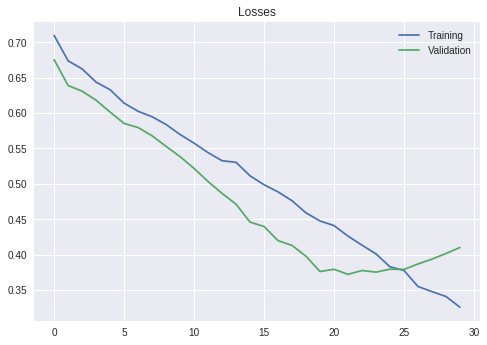

In [168]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

## Task B

In [170]:
#Select data that does not have subtask_a == "OFF":
train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=lambda d: d.subtask_a == 'OFF')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_b)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 3520
Validation size: 880
defaultdict(<function _default_unk_index at 0x7fa37d683840>, {'TIN': 0, 'UNT': 1})


In [171]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 512
dropout = 0.5
n_hidden = (64, 32, 16, 8, 4)

pos_weight = torch.tensor([6.8], device = device) #deals with unbalanced classes

model = ClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, n_hidden = n_hidden)

optimizer = optim.Adam(model.parameters(), lr)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

t_losses, v_losses = train_helper('subtask_b', model, optimizer, loss_fn = loss_fn, epochs = 30, 
                                  train_loader=train_iterator, valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 1.3340

Validation Accuracy:
Got 112 / 880 correct (12.73)
[[  0 768]
 [  0 112]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       768
           1       0.13      1.00      0.23       112

   micro avg       0.13      0.13      0.13       880
   macro avg       0.06      0.50      0.11       880
weighted avg       0.02      0.13      0.03       880

Kappa 0.0000

Epoch: 1
Iteration 0, loss = 1.3140


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



Validation Accuracy:
Got 112 / 880 correct (12.73)
[[  0 768]
 [  0 112]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       768
           1       0.13      1.00      0.23       112

   micro avg       0.13      0.13      0.13       880
   macro avg       0.06      0.50      0.11       880
weighted avg       0.02      0.13      0.03       880

Kappa 0.0000

Epoch: 2
Iteration 0, loss = 1.2032

Validation Accuracy:
Got 112 / 880 correct (12.73)
[[  0 768]
 [  0 112]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       768
           1       0.13      1.00      0.23       112

   micro avg       0.13      0.13      0.13       880
   macro avg       0.06      0.50      0.11       880
weighted avg       0.02      0.13      0.03       880

Kappa 0.0000

Epoch: 3
Iteration 0, loss = 0.9265

Validation Accuracy:
Got 112 / 880 correct (12.73)
[[  0 768]
 [  0 112]]
              precisi

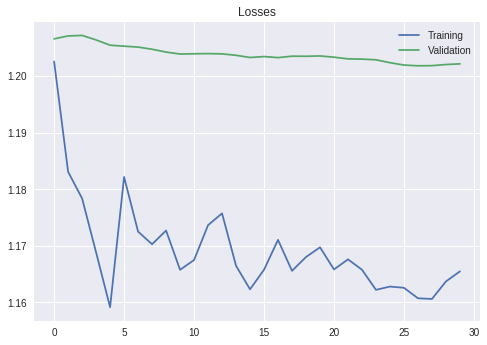

In [172]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

##Task C

In [143]:


train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=lambda d: d.subtask_a == 'OFF' and d.subtask_b == 'TIN')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_c)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 3101
Validation size: 775
defaultdict(<function _default_unk_index at 0x7fa37d683840>, {'IND': 0, 'GRP': 1, 'OTH': 2})


In [153]:
#CONV with Glove
embedding_dim = 200
window_size = 3
lr = 0.00025
out_channels = 512
dropout = 0.5
weight = torch.tensor([1.6, 3.7 ,8.4], device = device) #deals with unbalanced classes

model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, dropout, num_classes=3)

optimizer = optim.Adam(model.parameters(), lr)
loss_fn = nn.CrossEntropyLoss(weight = weight)


t_losses, v_losses = train_helper('subtask_c', model, optimizer, loss_fn = loss_fn, epochs = 20, train_loader=train_iterator, valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 2.1998

Validation Accuracy:
Got 371 / 775 correct (47.87)
[[209 234  33]
 [ 38 149  20]
 [ 23  56  13]]
              precision    recall  f1-score   support

           0       0.77      0.44      0.56       476
           1       0.34      0.72      0.46       207
           2       0.20      0.14      0.16        92

   micro avg       0.48      0.48      0.48       775
   macro avg       0.44      0.43      0.40       775
weighted avg       0.59      0.48      0.49       775

Kappa 0.1654

Epoch: 1
Iteration 0, loss = 1.3425

Validation Accuracy:
Got 445 / 775 correct (57.42)
[[288 155  33]
 [ 45 141  21]
 [ 31  45  16]]
              precision    recall  f1-score   support

           0       0.79      0.61      0.69       476
           1       0.41      0.68      0.51       207
           2       0.23      0.17      0.20        92

   micro avg       0.57      0.57      0.57       775
   macro avg       0.48      0.49      0.47       775
weighted av

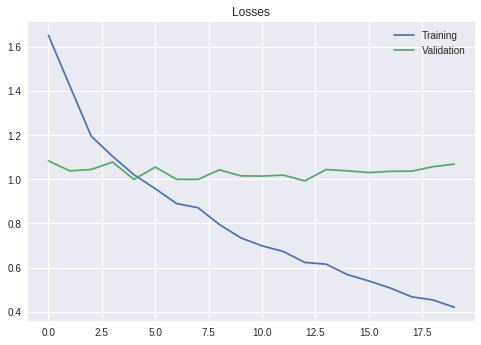

In [154]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()